In [ ]:
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import seaborn as sns
import glob
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from matplotlib import pyplot as plt
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Conv1D, Dropout, MaxPooling1D, Flatten, Dense
import tensorflow as tf
from sklearn.utils import resample
from sklearn.utils import shuffle
import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/NLP_KG
%ls

/content/drive/MyDrive/NLP_KG
dataset/


In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def preprocess_sentence(sentence, stop_words):
    sentence = sentence.lower()
    sentence = re.sub(r'[^\w\s]','',sentence)
    word_tokens = word_tokenize(sentence) 
    processed_sentence = ''
    for word in word_tokens:
        if word not in stop_words:
            processed_sentence += word + ' '
    processed_sentence = processed_sentence[:-1]
    return processed_sentence 

In [ ]:
folder_name = './dataset/gene-sequencing/'

directories = glob.glob(folder_name + '*')
dataset = {}
number = 1
stop_words = set(stopwords.words("english"))
for directory in directories:
    if directory != str(folder_name + '10'): #ignore the last folder I will use it as test paper
        text_file = glob.glob(directory + '/*Stanza-out.txt')[0]
        sentence_file = glob.glob(directory + '/*sentences.txt')[0]
        sentence_dict = {}
        print('Reading file: ' + text_file)
        id = 1
        f = open(text_file, 'r')
        for sentence in f:
            sentence_dict[id] = [np.array(embed([preprocess_sentence(sentence, stop_words)])[0], dtype='float32'), 0]
            id = id + 1
        f = open(sentence_file, 'r')
        for sentence_num in f:
            sentence_dict[int(sentence_num)][1] = 1
        for k, v in sentence_dict.items():
            dataset[number] = v
            number += 1
        print('Done reading')
print("I AM DONE")

Reading file: ./dataset/gene-sequencing/5/Love et al., 2016-Stanza-out.txt
Done reading
Reading file: ./dataset/gene-sequencing/2/Cai et al., 2013-Stanza-out.txt
Done reading
Reading file: ./dataset/gene-sequencing/3/Fitak et al., 2015-Stanza-out.txt
Done reading
Reading file: ./dataset/gene-sequencing/9/Vaghefi et al., 2017-Stanza-out.txt
Done reading
Reading file: ./dataset/gene-sequencing/0/Blanc-Mathieu et al., 2014-Stanza-out.txt
Done reading
Reading file: ./dataset/gene-sequencing/8/Sharko et al., 2019-Stanza-out.txt
Done reading
Reading file: ./dataset/gene-sequencing/6/Nock et al., 2016-Stanza-out.txt
Done reading
Reading file: ./dataset/gene-sequencing/7/Schatz et al., 2014-Stanza-out.txt
Done reading
Reading file: ./dataset/gene-sequencing/4/Li et al., 2010-Stanza-out.txt
Done reading
Reading file: ./dataset/gene-sequencing/1/Brand et al., 2018-Stanza-out.txt
Done reading
I AM DONE


In [ ]:
dataset = pd.DataFrame(dataset).T
dataset.columns = ['Sentence', 'Label']
dataset

,Sentence,Label
1,"[-0.06335544, -0.029147001, 0.027340723, 0.068...",0
2,"[-0.0368622, -0.042071916, -0.039972927, 0.026...",0
3,"[-0.0660406, 0.035976294, 0.08232539, -0.00499...",0
4,"[-0.07792691, 0.06651248, -0.024652002, 0.0380...",0
5,"[0.050704177, -0.06849507, -0.049851988, 0.048...",0
...,...,...
2095,"[-0.04670579, 0.023381073, 0.004099612, 0.0368...",0
2096,"[0.008249804, -0.017745443, 0.026740575, 0.052...",1
2097,"[-0.06469606, -0.014690032, -0.006760066, 0.05...",0
2098,"[-0.034021787, 0.0023185122, -0.02650469, 0.01...",0


In [ ]:
data_majority = dataset[dataset['Label'] == 0]
data_minority = dataset[dataset['Label'] == 1]
print(data_majority.shape)
print(data_minority.shape)
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0])
data_upsampled = shuffle(pd.concat([data_majority, data_minority_upsampled]))
data_upsampled

(1816, 2)
(283, 2)


,Sentence,Label
1125,"[-0.029554103, -0.068100214, -0.010639429, 0.0...",1
1363,"[0.040270723, -0.03651356, -0.06874573, -0.064...",0
2006,"[0.0402314, -0.08161804, 0.0068468098, -0.0241...",0
368,"[0.021787837, -0.017352048, 0.017772485, 0.003...",0
708,"[0.06723089, 0.009076664, -0.0050326185, 0.055...",0
...,...,...
88,"[-0.01221154, -0.035092063, 0.0089138625, 0.00...",0
760,"[0.075714186, 0.0051085046, -0.05513597, 0.051...",0
1745,"[-0.023621406, -0.06823426, -0.0051304097, -0....",1
1443,"[0.0004635851, -0.022600366, -0.033079013, -0....",0


In [ ]:
X = []
for val in data_upsampled['Sentence']:
    X.append(list(val))
X = np.array(X).reshape(len(X), 512, 1)
print(X.shape)

(3632, 512, 1)


In [ ]:
y = data_upsampled['Label'].values
y = np.array(y, dtype=int)
y

array([1, 0, 0, ..., 1, 0, 1])

In [ ]:
model = Sequential()
model.add(Input(shape=(512, 1)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=16, kernel_size=1, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 510, 32)           128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 510, 16)           528       
_________________________________________________________________
flatten (Flatten)            (None, 8160)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1044608   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6

In [ ]:
model.compile(loss='binary_crossentropy',
optimizer='adam',
metrics='accuracy')

In [ ]:
model.fit(X, y,epochs = 50, batch_size=32, validation_split=0.2, 
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])

Epoch 1/50
91/91 [==============================] - 28s 6ms/step - loss: 0.9013 - accuracy: 0.4660 - val_loss: 0.5669 - val_accuracy: 0.2462
Epoch 2/50
91/91 [==============================] - 0s 4ms/step - loss: 0.5035 - accuracy: 0.4336 - val_loss: 0.4601 - val_accuracy: 0.2957
Epoch 3/50
91/91 [==============================] - 0s 4ms/step - loss: 0.4415 - accuracy: 0.4254 - val_loss: 0.3926 - val_accuracy: 0.5213
Epoch 4/50
91/91 [==============================] - 0s 4ms/step - loss: 0.4087 - accuracy: 0.3752 - val_loss: 0.4342 - val_accuracy: 0.2669
Epoch 5/50
91/91 [==============================] - 0s 4ms/step - loss: 0.3797 - accuracy: 0.2938 - val_loss: 0.8004 - val_accuracy: 0.4759
Epoch 6/50
91/91 [==============================] - 0s 4ms/step - loss: 0.4370 - accuracy: 0.5593 - val_loss: 0.5629 - val_accuracy: 0.6864
Epoch 7/50
91/91 [==============================] - 0s 4ms/step - loss: 0.4133 - accuracy: 0.4808 - val_loss: 0.4162 - val_accuracy: 0.7221
Epoch 8/50
91/91 [=

In [ ]:
text_file = open(folder_name+'10/Varshney et al., 2012-Stanza-out.txt')
id = 1
test_data = {}
for sentence in text_file:
    test_data[id] = [np.array(embed([preprocess_sentence(sentence, stop_words)])[0], dtype='float32'), 0]
    id = id + 1
imp_sen_file = open(folder_name+ '10/sentences.txt')
for imp_sen_num in imp_sen_file:
    num = int(imp_sen_num)
    test_data[num][1] = 1

In [ ]:
test_data = pd.DataFrame(test_data).T
test_data.columns = ['Sentence', 'Label']

In [ ]:
test_data

,Sentence,Label
1,"[-0.06335544, -0.029147001, 0.027340723, 0.068...",0
2,"[0.06869196, -0.060556266, 0.05086742, 0.01811...",0
3,"[-0.0660406, 0.035976294, 0.08232539, -0.00499...",0
4,"[0.001154256, 0.06944055, 0.032809313, -0.0128...",0
5,"[-0.021191048, -0.057707787, -0.043722693, 0.0...",1
...,...,...
158,"[-0.022267858, -0.065829806, 0.06222481, 0.014...",0
159,"[0.070805594, -0.020288588, 0.010987466, 0.079...",0
160,"[0.04860682, -0.03236747, 0.029217944, -0.0153...",0
161,"[-0.029471917, -0.064219825, 0.04674698, 0.058...",0


In [ ]:
X_test = []
for val in test_data['Sentence']:
    X_test.append(list(val))
# print("BEFORE", len(X_test))
X_test = np.array(X_test).reshape(len(X_test), 512, 1)
print(X_test.shape)

(162, 512, 1)


In [ ]:
y_test = test_data['Label'].values
y_test = np.array(y_test, dtype=int)

In [ ]:
y_pred = model.predict_classes(X_test)
y_pred

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1])

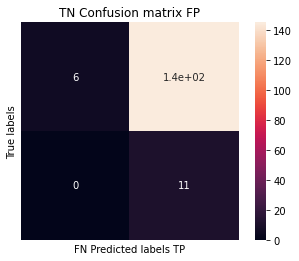

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, square=True)
plt.xlabel("FN Predicted labels TP")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('TN Confusion matrix FP')
plt.show()

In [ ]:
precision_recall_fscore_support(y_test, y_pred, average='micro')

(0.10493827160493827, 0.10493827160493827, 0.10493827160493827, None)

In [ ]:
precision_recall_fscore_support(y_test, y_pred, average='macro')

(0.5352564102564102, 0.5198675496688742, 0.10408482398260804, None)